# Gesture Recognition

A home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command that are as followed:

Gesture | Action
--------|--------
Thumbs up |  Increase the volume
Thumbs down | Decrease the volume
Left swipe | 'Jump' backwards 10 seconds
Right swipe | 'Jump' forward 10 seconds  
Stop | Pause the movie
<br>
<br>

### Objectives:<br>
1. **Generator:** The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully. <br>

2. **Model:** Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further. <br>

3. **Write up:** This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.<br>

### Importing Packages and setting up seed value

In [1]:
import numpy as np
import os
import datetime
import os
import matplotlib.pyplot as plt
from imageio import imread
from skimage import io, transform
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

#### Initialize path and vairables

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

# Batch size handled in class

batch_size = 30
img_size_ht = 120
img_size_wd = 120

### Defining Generator Function

In [4]:
def generator(source_path, folder_list, batch_size, factor_ht=0, factor_wd=0 ):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)


        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

In [5]:
def generator_new(source_path, folder_list, batch_size, factor_ht=0, factor_wd=0 ):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)


        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
#                     image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
#                     image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

In [6]:
def generator(source_path, folder_list, batch_size, factor_ht=0, factor_wd=0 ):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    img_idx = np.arange(0,30,2) #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)


        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),img_size_ht,img_size_wd,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                   # CROP 
                    if factor_ht!=0 or factor_wd!=0:
                        image_ht, image_wd, _ = image.shape
                        ht1 = int(factor_ht / 2)
                        ht2 = image_ht - int(factor_ht /2)
                        wd1 = int(factor_wd / 2)
                        wd2 = image_wd - int(factor_wd / 2)
                        image=image[ht1:ht2, wd1:wd2,:]
                    
                    # Resize and Normalize
                    image = resize(image,(img_size_ht,img_size_wd))
                    image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
            

#### Defining Fit function for the models

In [7]:
def run_model(model, batch_size = 30, epoch_num=25):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = generator(train_path, train_doc, batch_size)
        val_generator = generator(val_path, val_doc, batch_size)
        

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        
        callbacks_list = [checkpoint, LR]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        return history

In [8]:
def run_model_new(model, batch_size = 30, epoch_num=25):
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        train_generator = generator_new(train_path, train_doc, batch_size)
        val_generator = generator_new(val_path, val_doc, batch_size)
        

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=5) # write the REducelronplateau code here
        
        callbacks_list = [checkpoint, LR]
        
        
        # Let us create the train_generator and the val_generator which will be used in .fit_generator.
        if (num_train_sequences%batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/batch_size)
        else:
            steps_per_epoch = (num_train_sequences//batch_size) + 1

        if (num_val_sequences%batch_size) == 0:
            validation_steps = int(num_val_sequences/batch_size)
        else:
            validation_steps = (num_val_sequences//batch_size) + 1
       
        # Let us now fit the model. This will start training the model and with the help of the checkpoints, 
        # you'll be able to save the model at the end of each epoch.
        history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epoch_num, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        
        return history

#### Defining Loss function that will be used to plot the graph

In [9]:
def loss(history):
        acc = history.history['categorical_accuracy']
        val_acc = history.history['val_categorical_accuracy']

        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs_range = range(len(history.history['loss']))

        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

**More parameters**

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5

# training sequences = 663
# validation sequences = 100
# epochs = 25


### Testing Generator function

Source path =  Project_data/train ; batch size = 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


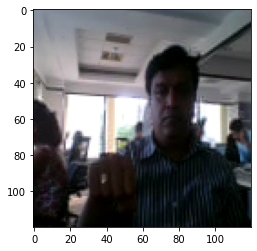

In [11]:
# Test Generator Function

xtrain=generator(train_path,train_doc, 32 )
x=next(xtrain)
plt.imshow(x[0][1][1])

Source path =  Project_data/train ; batch size = 32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


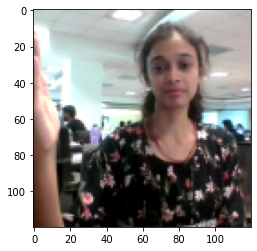

In [12]:
# Test Crop in Generator Function

xtrain=generator(train_path,train_doc, 32, factor_ht=10, factor_wd=10)
x=next(xtrain)
plt.imshow(x[0][1][1])

### Define Keras Classes

In [13]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, LeakyReLU
from tensorflow.keras.applications import EfficientNetB0

## Developing Models

### Model 1 

- Vanilla Model

In [14]:
model_7 = Sequential()

model_7.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
           
model_7.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_7.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))       
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_7.add(TimeDistributed(BatchNormalization()))
model_7.add(TimeDistributed(Activation('relu')))          
model_7.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_7.add(TimeDistributed(Flatten()))
model_7.add(LSTM(256,dropout=0.2))
model_7.add(Dense(256, activation='relu'))
model_7.add(Dropout(0.2))

model_7.add(Dense(5, activation='softmax'))

In [16]:
#write your model here
Input_shape = (15, img_size_ht,img_size_wd, 3)

lrelu = lambda x: LeakyReLU(alpha=0.1)(x)

model_7a = Sequential()

model_7a.add(TimeDistributed(Conv2D(16, (3,3), padding = "same"), input_shape=(15,img_size_ht,img_size_wd,3)))
model_7a.add(TimeDistributed(BatchNormalization()))
model_7a.add(TimeDistributed(Activation(lrelu)))
           
model_7a.add(TimeDistributed(Conv2D(32,(3,3),padding = "same")))
model_7a.add(TimeDistributed(BatchNormalization()))
model_7a.add(TimeDistributed(Activation(lrelu)))
model_7a.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7a.add(TimeDistributed(Conv2D(64, (3,3),  padding = "same")))
model_7a.add(TimeDistributed(BatchNormalization()))
model_7a.add(TimeDistributed(Activation(lrelu)))
model_7a.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))
           
model_7a.add(TimeDistributed(Conv2D(128,(3,3), padding = "same")))
model_7a.add(TimeDistributed(BatchNormalization()))
model_7a.add(TimeDistributed(Activation(lrelu)))       
model_7a.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))

model_7a.add(TimeDistributed(Conv2D(256,(3,3), padding = "same")))
model_7a.add(TimeDistributed(BatchNormalization()))
model_7a.add(TimeDistributed(Activation(lrelu)))          
model_7a.add(TimeDistributed(MaxPooling2D(pool_size= (2,2))))


model_7a.add(TimeDistributed(Flatten()))
model_7a.add(LSTM(256,dropout=0.2))
model_7a.add(Dense(256, activation=lrelu))
model_7a.add(Dropout(0.2))

model_7a.add(Dense(5, activation='softmax'))



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 120, 120, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 120, 120, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 120, 120, 32)  

Epoch 9/25
23/23 [==============================] - ETA: 0s - loss: 0.6902 - categorical_accuracy: 0.8160
Epoch 9: saving model to model_init_2022-04-1123_24_45.029555\model-00009-0.69019-0.81599-2.61242-0.17000.h5
23/23 [==============================] - 193s 8s/step - loss: 0.6902 - categorical_accuracy: 0.8160 - val_loss: 2.6124 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 10/25
23/23 [==============================] - ETA: 0s - loss: 0.6149 - categorical_accuracy: 0.8552
Epoch 10: saving model to model_init_2022-04-1123_24_45.029555\model-00010-0.61488-0.85520-2.64145-0.17000.h5
23/23 [==============================] - 193s 8s/step - loss: 0.6149 - categorical_accuracy: 0.8552 - val_loss: 2.6414 - val_categorical_accuracy: 0.1700 - lr: 2.0000e-04
Epoch 11/25
23/23 [==============================] - ETA: 0s - loss: 0.5616 - categorical_accuracy: 0.8748
Epoch 11: saving model to model_init_2022-04-1123_24_45.029555\model-00011-0.56159-0.87481-2.54160-0.22000.h5

Epoch 11

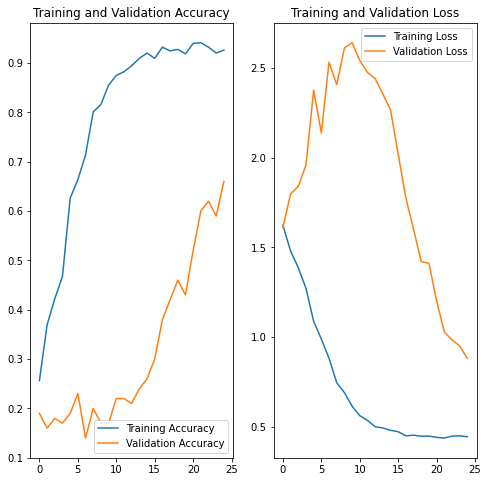

In [16]:
optimiser = Adam(learning_rate=0.001) 
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())
history= run_model(model_7)
loss(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 120, 120, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 120, 120, 32)  4640     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 15, 120, 120, 32)  

Epoch 9/25
23/23 [==============================] - ETA: 0s - loss: 0.4045 - categorical_accuracy: 0.8778
Epoch 9: saving model to model_init_2022-04-1201_15_18.418752\model-00009-0.40454-0.87783-2.09422-0.28000.h5
23/23 [==============================] - 196s 9s/step - loss: 0.4045 - categorical_accuracy: 0.8778 - val_loss: 2.0942 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 10/25
23/23 [==============================] - ETA: 0s - loss: 0.3150 - categorical_accuracy: 0.9140
Epoch 10: saving model to model_init_2022-04-1201_15_18.418752\model-00010-0.31502-0.91403-2.29003-0.35000.h5
23/23 [==============================] - 196s 9s/step - loss: 0.3150 - categorical_accuracy: 0.9140 - val_loss: 2.2900 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04
Epoch 11/25
23/23 [==============================] - ETA: 0s - loss: 0.2794 - categorical_accuracy: 0.9246
Epoch 11: saving model to model_init_2022-04-1201_15_18.418752\model-00011-0.27937-0.92459-2.11425-0.32000.h5

Epoch 11

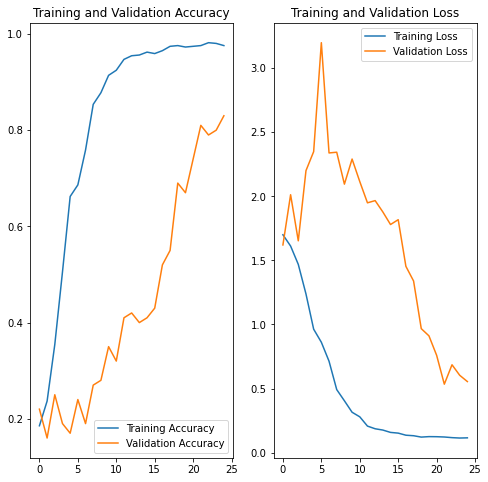

In [17]:
optimiser = RMSprop(learning_rate=0.001) 
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())
history= run_model(model_7)
loss(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 15, 120, 120, 16)  0        
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 120, 120, 32)  4640     
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 120, 120, 32)

Epoch 9/25
23/23 [==============================] - ETA: 0s - loss: 0.5901 - categorical_accuracy: 0.8401
Epoch 9: saving model to model_init_2022-04-1201_15_18.418752\model-00009-0.59008-0.84012-2.15326-0.36000.h5
23/23 [==============================] - 181s 8s/step - loss: 0.5901 - categorical_accuracy: 0.8401 - val_loss: 2.1533 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04
Epoch 10/25
23/23 [==============================] - ETA: 0s - loss: 0.5599 - categorical_accuracy: 0.8477
Epoch 10: saving model to model_init_2022-04-1201_15_18.418752\model-00010-0.55987-0.84766-2.16031-0.36000.h5
23/23 [==============================] - 189s 8s/step - loss: 0.5599 - categorical_accuracy: 0.8477 - val_loss: 2.1603 - val_categorical_accuracy: 0.3600 - lr: 2.0000e-04
Epoch 11/25
23/23 [==============================] - ETA: 0s - loss: 0.5354 - categorical_accuracy: 0.8718
Epoch 11: saving model to model_init_2022-04-1201_15_18.418752\model-00011-0.53543-0.87179-1.97607-0.36000.h5

Epoch 11

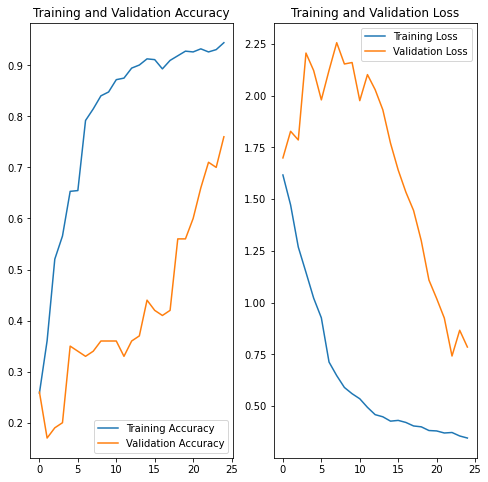

In [18]:
optimiser = Adam(learning_rate=0.001) 
model_7a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7a.summary())
history= run_model(model_7a)
loss(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_40 (TimeDi  (None, 15, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 15, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 15, 120, 120, 16)  0        
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, 15, 120, 120, 32)  4640     
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, 15, 120, 120, 32)

Epoch 9/25
23/23 [==============================] - ETA: 0s - loss: 0.2396 - categorical_accuracy: 0.9367
Epoch 9: saving model to model_init_2022-04-1201_15_18.418752\model-00009-0.23956-0.93665-0.79186-0.77000.h5
23/23 [==============================] - 191s 8s/step - loss: 0.2396 - categorical_accuracy: 0.9367 - val_loss: 0.7919 - val_categorical_accuracy: 0.7700 - lr: 2.0000e-04
Epoch 10/25
23/23 [==============================] - ETA: 0s - loss: 0.1292 - categorical_accuracy: 0.9713
Epoch 10: saving model to model_init_2022-04-1201_15_18.418752\model-00010-0.12918-0.97134-0.70488-0.82000.h5
23/23 [==============================] - 190s 8s/step - loss: 0.1292 - categorical_accuracy: 0.9713 - val_loss: 0.7049 - val_categorical_accuracy: 0.8200 - lr: 2.0000e-04
Epoch 11/25
23/23 [==============================] - ETA: 0s - loss: 0.1140 - categorical_accuracy: 0.9789
Epoch 11: saving model to model_init_2022-04-1201_15_18.418752\model-00011-0.11398-0.97888-0.70094-0.77000.h5
23/23 [==

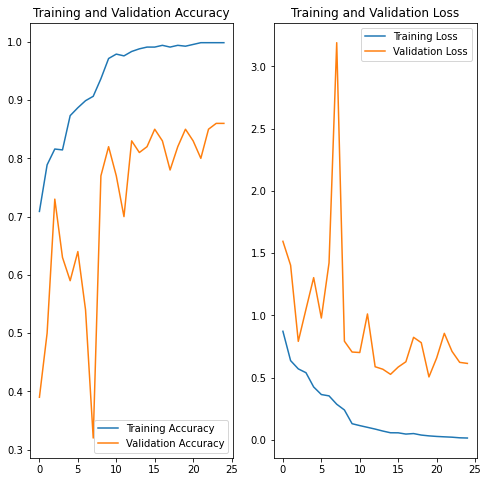

In [19]:
optimiser = RMSprop(learning_rate=0.001) 
model_7a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7a.summary())
history= run_model(model_7a)
loss(history)

In [ ]:

optimiser = Adam(learning_rate=0.001) 
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())
history= run_model_new(model_7)
loss(history)
# add Codeadd Markdown



In [ ]:
optimiser = RMSprop(learning_rate=0.001) 
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())
history= run_model_new(model_7)
loss(history)



In [ ]:
optimiser = Adam(learning_rate=0.001) 
model_7a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7a.summary())
history= run_model_new(model_7a)
loss(history)


In [ ]:

optimiser = RMSprop(learning_rate=0.001) 
model_7a.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7a.summary())
history= run_model_new(model_7a)
loss(history)


This is Complete Overfit. But seeing the ipward trend in accracy and Validation Loss, running the model for more epoch we could see improvement in Validation parameters.